In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from IPython.display import display, Latex, Math, Image
from scipy import interpolate
from scipy.optimize import least_squares, minimize, brute

# Function for displaying expressions
def eq_disp(varstring, expr, unit=""):
    display(Latex(f"${varstring}={sp.latex(expr)} \: {unit}$"))

# Description of the dynamic system

In [2]:
# Plant parameters
m1 = 0.269
m2 = 0.511
l_1 = 0.307
l_2 = 0.307
J_1 = 1/12*m1*l_1**2
J_2 = 1/12*m2*l_2**2
g = 9.82
s = ct.tf('s')

## Block diagram

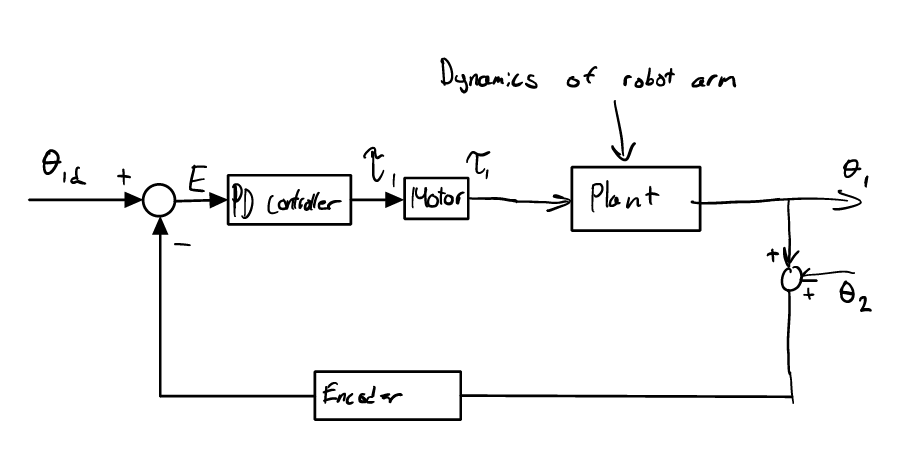

In [3]:
Image('Block diagram.png')

# Initialize simulations with guessed c_1 and c_2

Simulate $\theta_1$

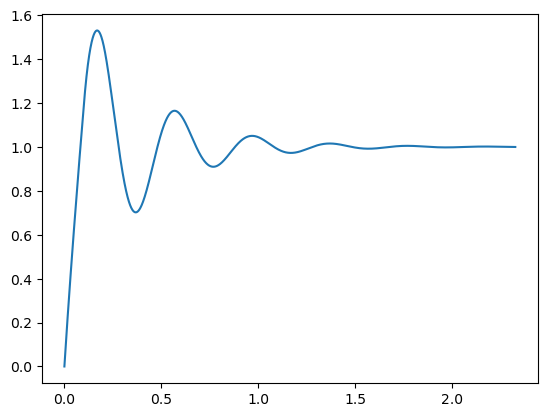

In [4]:
# Guess c_1
c_1 = 0.4

# Plant transfer functions
G1 = (16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2)/(s*(16*J_1*J_2*s + 4*J_1*l_2**2*m2*s + 16*J_2*c_1 + 4*J_2*l_1**2*m1*s + 16*J_2*l_1**2*m2*s + 4*c_1*l_2**2*m2 + l_1**2*l_2**2*m1*m2*s))

# Time delay [s]
T_delay1 = 0.1

# Make padé approximation of time delay
# 10th order approximation
n_pade1 = 10
num_pade1, den_pade1 = ct.pade(T_delay1, n_pade1)
H_pade1 = ct.tf(num_pade1, den_pade1)

# Conversion factor from the input given to the torque
input_to_torque1 = 40

# Input PD-values
input_Kp1 = 5
input_Kd1 = 0.35

# Converted PD-values
Kp1 = input_Kp1*input_to_torque1
Kd1 = input_Kd1*input_to_torque1

# System definition
Gc1 = Kp1 + Kd1*s
L1 = Gc1*G1
T1 = ct.feedback(L1, H_pade1)

t1_sim, y1_sim = ct.step_response(T1)
plt.plot(t1_sim, y1_sim)

Simulate $\theta_2$

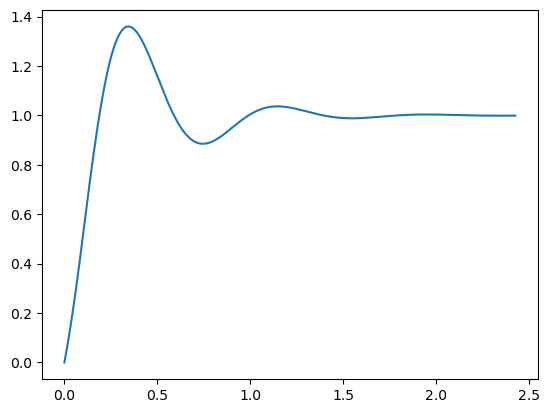

In [5]:
# Guess c_2
c_2 = 0.045

# Plant transfer function
G2 = (16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2)/(s*(16*J_1*J_2*s + 16*J_1*c_2 + 4*J_1*l_2**2*m2*s + 4*J_2*l_1**2*m1*s + 16*J_2*l_1**2*m2*s + 4*c_2*l_1**2*m1 + 16*c_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2*s))

# Time delay [s]
T_delay2 = 0.1

# Make padé approximation of time delay
# 10th order approximation
n_pade2 = 10
num_pade2, den_pade2 = ct.pade(T_delay2, n_pade2)
H_pade2 = ct.tf(num_pade2, den_pade2)

# Conversion factor from the input given to the torque
input_to_torque2 = 40

# Input PD-values
input_Kp2 = 1.5
input_Kd2 = 0.1

# Converted PD-values
Kp2 = input_Kp2*input_to_torque2
Kd2 = input_Kd2*input_to_torque2

# System definition
Gc2 = Kp2 + Kd2*s
L2 = Gc2*G2
T2 = ct.feedback(L2, H_pade2)

t2_sim, y2_sim = ct.step_response(T2)
plt.plot(t2_sim, y2_sim)

# Finding c_1

Raw measurement data

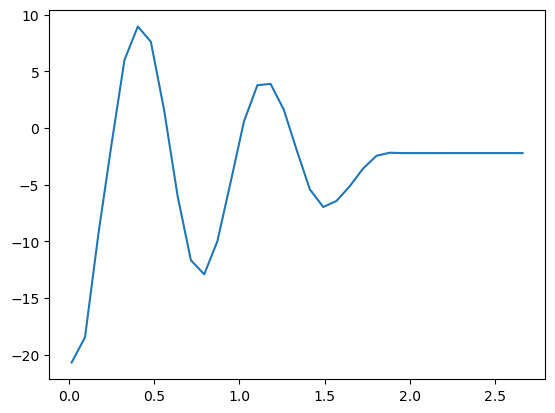

In [6]:
t1_real_raw = np.loadtxt('data/theta1_kp5_kd0.35')[0]
yout1_real_raw = np.loadtxt('data/theta1_kp5_kd0.35')[1]

plt.plot(t1_real_raw, yout1_real_raw)

Get correct values by subtracting the minimum og the data and normalizing

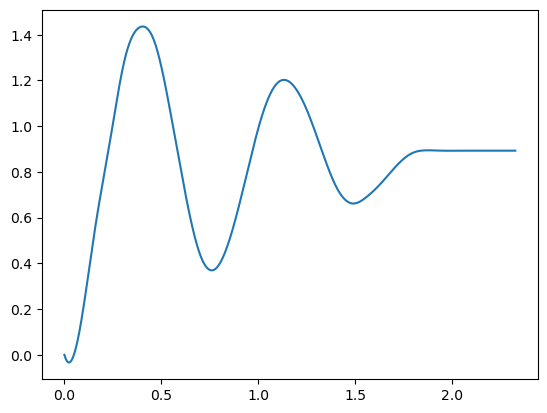

In [7]:
def load_and_clean(datapath, t_sim, y_sim):
    # Load data
    t_real_raw = np.loadtxt(datapath)[0]
    yout_real_raw = np.loadtxt(datapath)[1]
    
    # Normalize
    t_real =  t_real_raw - np.min(t_real_raw)
    yout_real = -(yout_real_raw - np.min(yout_real_raw))/np.min(yout_real_raw)
    
    # Interpolate to same data points as simulation
    tck = interpolate.splrep(t_real, yout_real, s=0)
    ynew = interpolate.splev(t_sim, tck, der=0)
    
    return t_sim, ynew

t1_real, y1_real = load_and_clean('data/theta1_kp5_kd0.35', t1_sim, y1_sim)
plt.plot(t1_real, y1_real)

In [8]:
# Define function to minimize
def y1_difference(c_1):

    # Plant transfer functions
    G1 = (16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2)/(s*(16*J_1*J_2*s + 4*J_1*l_2**2*m2*s + 16*J_2*c_1 + 4*J_2*l_1**2*m1*s + 16*J_2*l_1**2*m2*s + 4*c_1*l_2**2*m2 + l_1**2*l_2**2*m1*m2*s))

    # Input PD-values
    input_Kp1 = 5
    input_Kd1 = 0.35

    # Converted PD-values
    Kp1 = input_Kp1*input_to_torque1
    Kd1 = input_Kd1*input_to_torque1

    # System definition
    Gc1 = Kp1 + Kd1*s
    L1 = Gc1*G1
    T1 = ct.feedback(L1, H_pade1)

    t1_sim, y1_sim = ct.step_response(T1)
    
    t1_real, y1_real = load_and_clean('data/theta1_kp5_kd0.35', t1_sim, y1_sim)
    
    return np.sum((y1_real - y1_sim)**2)

c_1 = minimize(y1_difference, 0.4, bounds=[(0, 0.9)]).x[0]
#c_1 = brute(y1_difference, ranges=[(0, 0.9)])[0]
c_1

0.3999595267266356

Show simulated response

(-0.2, 2.0)

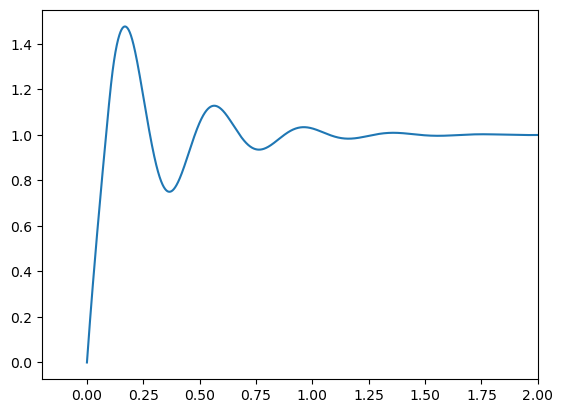

In [9]:
c_1 = 0.42

# Plant transfer functions
G1 = (16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2)/(s*(16*J_1*J_2*s + 4*J_1*l_2**2*m2*s + 16*J_2*c_1 + 4*J_2*l_1**2*m1*s + 16*J_2*l_1**2*m2*s + 4*c_1*l_2**2*m2 + l_1**2*l_2**2*m1*m2*s))

# Input PD-values
input_Kp1 = 5
input_Kd1 = 0.35

# Converted PD-values
Kp1 = input_Kp1*input_to_torque1
Kd1 = input_Kd1*input_to_torque1

# System definition
Gc1 = Kp1 + Kd1*s
L1 = Gc1*G1
T1 = ct.feedback(L1, H_pade1)

t1_sim, y1_sim = ct.step_response(T1)
plt.plot(t1_sim, y1_sim)
plt.xlim(-0.2, 2)

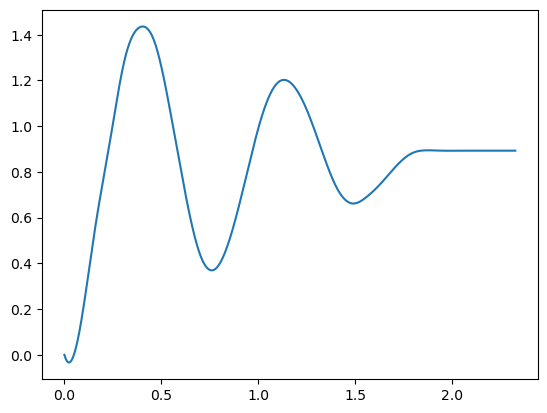

In [10]:
plt.plot(t1_real, y1_real)

# Finding c_2

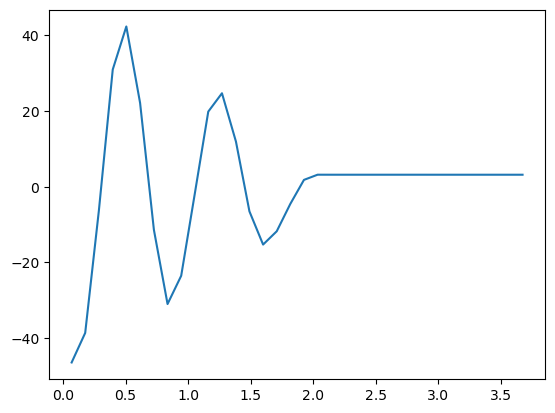

In [11]:
t1_real_raw = np.loadtxt('data/theta2_kp1.5_kd0.1')[0]
yout1_real_raw = -np.loadtxt('data/theta2_kp1.5_kd0.1')[1]

plt.plot(t1_real_raw, yout1_real_raw)

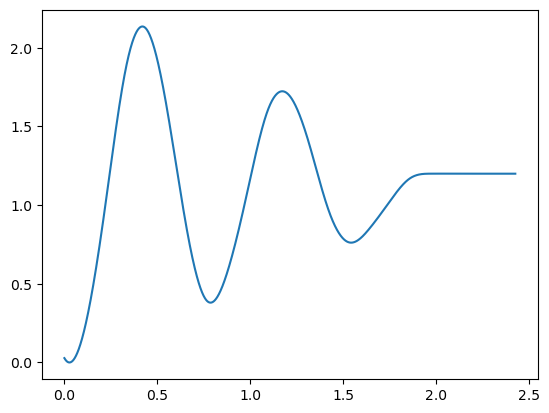

In [12]:
t2_real, y2_real_temp = load_and_clean('data/theta2_kp1.5_kd0.1', t2_sim, y2_sim)
y2_real = -y2_real_temp-np.min(-y2_real_temp)
plt.plot(t2_real, y2_real)

In [13]:
# Define function to minimize
def y2_difference(c_2):

    # Plant transfer functions
    G2 = (16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2)/(s*(16*J_1*J_2*s + 16*J_1*c_2 + 4*J_1*l_2**2*m2*s + 4*J_2*l_1**2*m1*s + 16*J_2*l_1**2*m2*s + 4*c_2*l_1**2*m1 + 16*c_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2*s))
    
    # Input PD-values
    input_Kp2 = 1.5
    input_Kd2 = 0.1

    # Converted PD-values
    Kp2 = input_Kp2*input_to_torque2
    Kd2 = input_Kd2*input_to_torque2

    # System definition
    Gc2 = Kp2 + Kd2*s
    L2 = Gc2*G2
    T2 = ct.feedback(L2, H_pade2)

    t2_sim, y2_sim = ct.step_response(T2)
    
    t2_real, y2_real = load_and_clean('data/theta2_kp1.5_kd0.1', t2_sim, y2_sim)
    
    return np.sum((y2_real - y2_sim)**2)

c_2 = minimize(y2_difference, 0.5, method='Nelder-Mead', bounds=[(0, 1)]).x[0]
c_2

0.41816406249999993

Show simulated response

(-0.2, 2.5)

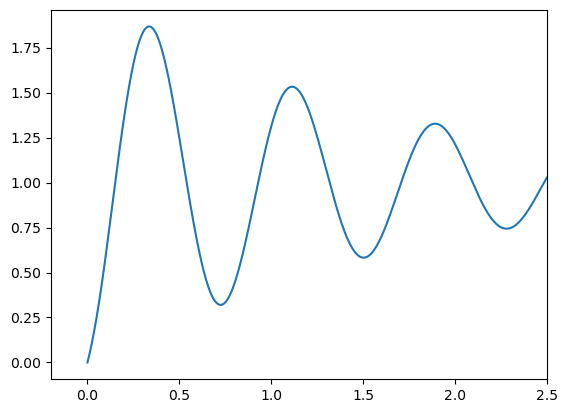

In [14]:
c_2 = 0.022

# Plant transfer function
G2 = (16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2)/(s*(16*J_1*J_2*s + 16*J_1*c_2 + 4*J_1*l_2**2*m2*s + 4*J_2*l_1**2*m1*s + 16*J_2*l_1**2*m2*s + 4*c_2*l_1**2*m1 + 16*c_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2*s))

# Input PD-values
input_Kp2 = 1.5
input_Kd2 = 0.1

# Converted PD-values
Kp2 = input_Kp2*input_to_torque2
Kd2 = input_Kd2*input_to_torque2

# System definition
Gc2 = Kp2 + Kd2*s
L2 = Gc2*G2
T2 = ct.feedback(L2, H_pade2)

t2_sim, y2_sim = ct.step_response(T2)
plt.plot(t2_sim, y2_sim)
plt.xlim(-0.2,2.5)

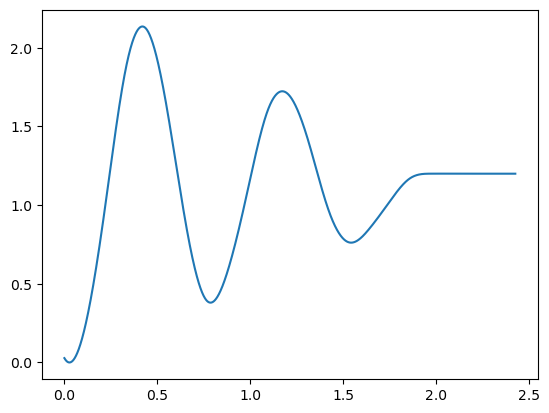

In [15]:
plt.plot(t2_real, y2_real)

# PD-tuning of $\theta_1$

## Requirements

20 % overshoot, 1/2 s rise time, 1 s settling time (2 % criterion). Neglecting the dynamics of $\theta_2$ and neglecting the dynamics of the motor and encoder (setting them equal to one). Gain margin must be over 5 dB and the phase margin must be over 50$^\circ$.

## Using Ziegler-Nichols tuning

$K_d$ is set to zero while $K_p$ until it reaches the ultimate gain, $K_u$, where the system reaches marginal stability

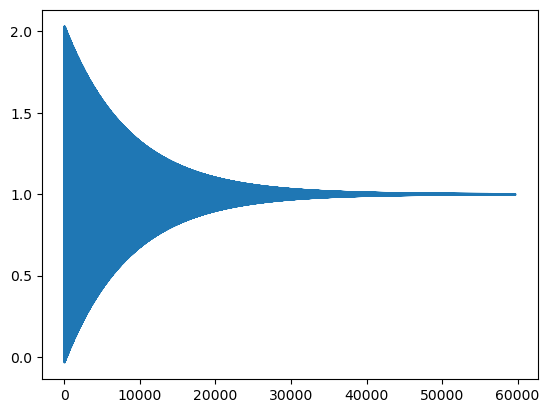

In [16]:
# Input PD-values
input_Kp1 = 6.285
input_Kd1 = 0

# Converted PD-values
Kp1 = input_Kp1*input_to_torque1
Kd1 = input_Kd1*input_to_torque1

# System definition
Gc1 = Kp1 + Kd1*s
L1 = Gc1*G1
T1 = ct.feedback(L1, H_pade1)

Ku1 = Kp1

t1_sim, y1_sim = ct.step_response(T1, T_num=100000)
plt.plot(t1_sim, y1_sim)

Then $K_p$ and $K_d$ values are calculated using the table.
https://en.m.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method

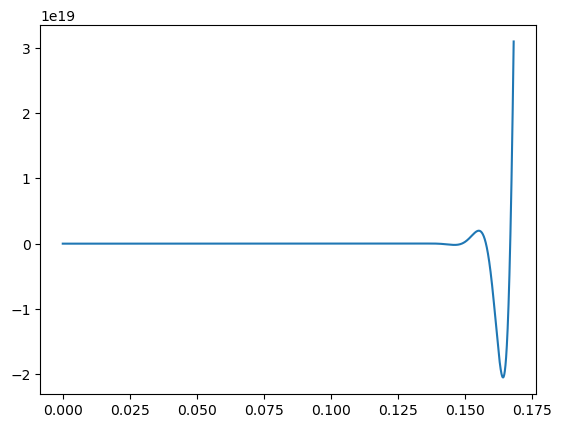

In [17]:
Tu1 = 10
input_Kp1 = 0.8*Ku1
input_Kd1 = 0.1*Ku1*Tu1

# Converted PD-values
Kp1 = input_Kp1*input_to_torque1
Kd1 = input_Kd1*input_to_torque1

# System definition
Gc1 = Kp1 + Kd1*s
L1 = Gc1*G1
T1 = ct.feedback(L1, H_pade1)

%matplotlib inline
t1_sim, y1_sim = ct.step_response(T1)
plt.plot(t1_sim, y1_sim)

## Using root locus - manual tuning

Closed loop system cannot reaches marginal stabilty with increasing $K_p$. After this, the quarter amplitude decay is reached, by increasing $K_p$

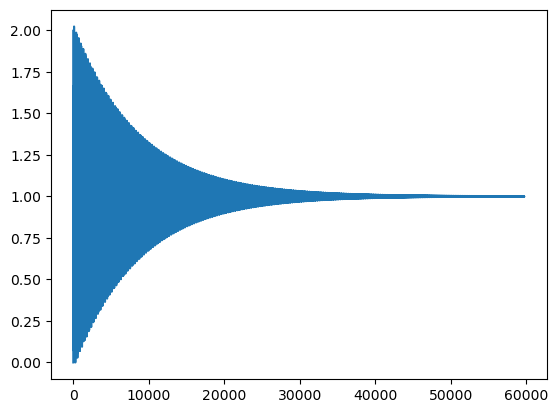

In [18]:
# Input PD-values
input_Kp1 = 6.285
input_Kd1 = 0

# Converted PD-values
Kp1 = input_Kp1*input_to_torque1
Kd1 = input_Kd1*input_to_torque1

# System definition
Gc1 = Kp1 + Kd1*s
L1 = Gc1*G1
T1 = ct.feedback(L1, H_pade1)

t1_sim, y1_sim = ct.step_response(T1)
plt.plot(t1_sim, y1_sim)

Reach the quarter amplitude decay, and tune $K_d$ to get desired characteristics

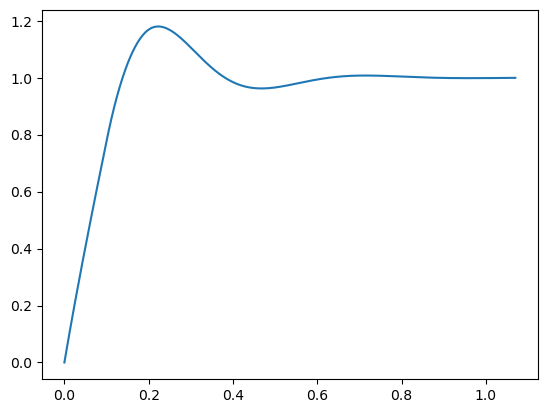

In [19]:
# Input PD-values
input_Kp1 = 3.6
input_Kd1 = 0.22

# Converted PD-values
Kp1 = input_Kp1*input_to_torque1
Kd1 = input_Kd1*input_to_torque1

# System definition
Gc1 = Kp1 + Kd1*s
L1 = Gc1*G1
T1 = ct.feedback(L1, H_pade1)

t1_sim, y1_sim = ct.step_response(T1)
plt.plot(t1_sim, y1_sim)

Root locus of uncompensated system with the characteristic equation found from
\begin{equation}
\frac{Y(s)}{R(s)}=\frac{KG(s)}{1+KG(s)},
\end{equation}

which gives the characteristic equation
\begin{equation}
1 + KG(s) = 0
\end{equation}

So for varying the proportional gain the root locus is


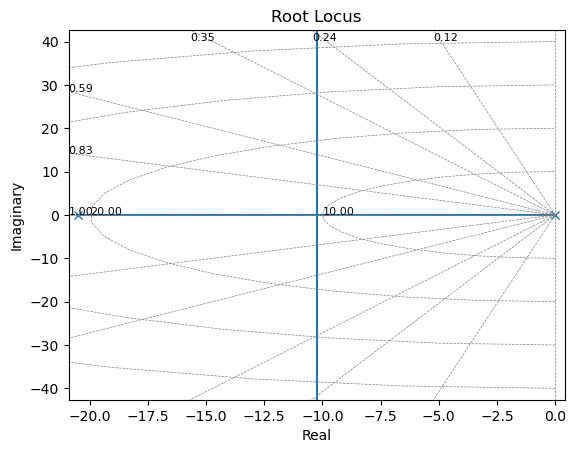

In [20]:
rlist1, klist1 = ct.rlocus(G1)

The root locus for varying the derivative gain, $K_D$.

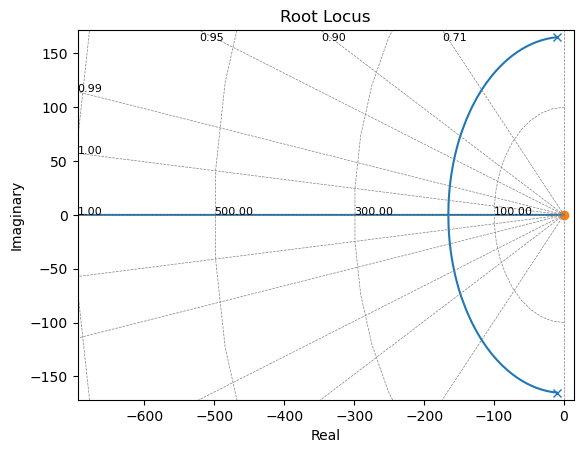

In [21]:
rlist1, klist1 = ct.rlocus(s*0.005263/(0.005263*s**2+0.1079*s + Kp1))

When $K_D$ increases the complex poles move to the left which
\begin{itemize}
    \item increases the associated damping ratio
    \item decrease the percent overshoot
    \item reduce the settling time
\end{itemize}

## Using the python PID-designer

Finding $K_p$

/Users/Mathias/opt/anaconda3/lib/python3.9/site-packages/control/freqplot.py:385: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_mag.axhline(y=0 if dB else 1, color='k', linestyle=':',


StateSpace(array([[ -20.49649998,    0.        ,    0.        ,    0.        ],
       [   1.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    1.        ,    0.        ,    0.        ],
       [   0.        ,  100.        ,    0.        , -100.        ]]), array([[  0.],
       [  0.],
       [  1.],
       [100.]]), array([[ 0., -1.,  0.,  0.]]), array([[0.]]))

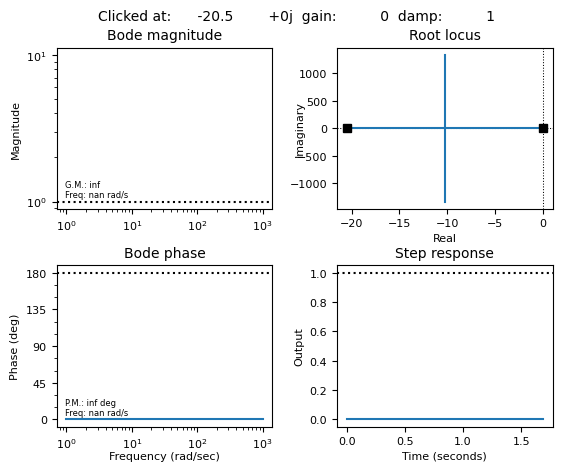

In [22]:
ct.rootlocus_pid_designer(G1)

Finding $K_D$

/Users/Mathias/opt/anaconda3/lib/python3.9/site-packages/control/freqplot.py:385: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_mag.axhline(y=0 if dB else 1, color='k', linestyle=':',


StateSpace(array([[ -20.49649998, -144.        ,    0.        ,    0.        ],
       [   1.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    1.        ,    0.        ,    0.        ],
       [   0.        ,  100.        ,    0.        , -100.        ]]), array([[-144.],
       [   0.],
       [   1.],
       [ 100.]]), array([[ 0., -1.,  0.,  0.]]), array([[0.]]))

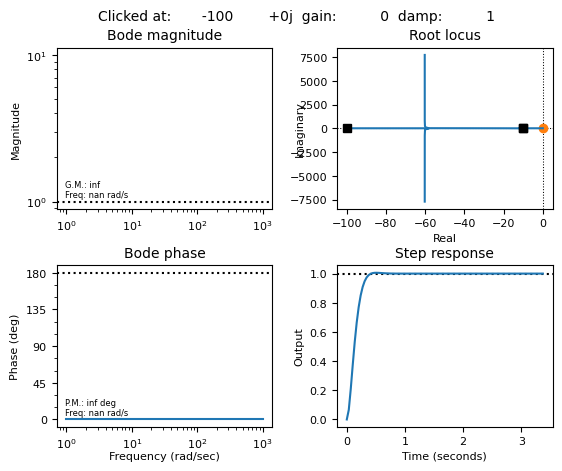

In [23]:
ct.rootlocus_pid_designer(G1, gain='D', Kp0=Kp1)

/Users/Mathias/opt/anaconda3/lib/python3.9/site-packages/control/freqplot.py:385: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_mag.axhline(y=0 if dB else 1, color='k', linestyle=':',


StateSpace(array([[-2.04965e+01, -1.02400e+03,  0.00000e+00,  8.80000e+02],
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  1.00000e+00,  0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  1.00000e+02,  0.00000e+00, -1.00000e+02]]), array([[-1.024e+03],
       [ 0.000e+00],
       [ 1.000e+00],
       [ 1.000e+02]]), array([[ 0., -1.,  0.,  0.]]), array([[0.]]))

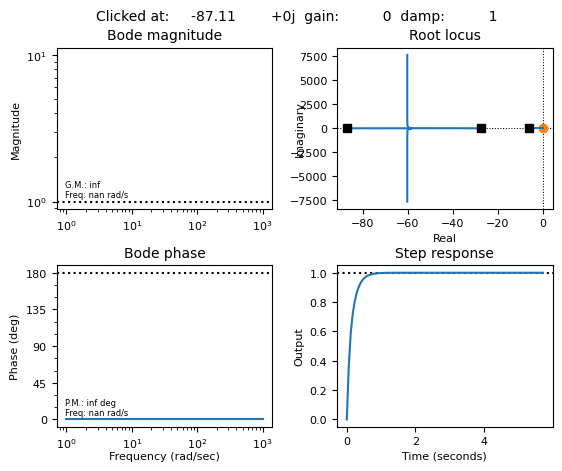

In [24]:
ct.rootlocus_pid_designer(G1, gain='D', Kp0=Kp1, Kd0=Kd1)

In [25]:
ct.step_info(T1)

{'RiseTime': 0.10681864033613185,
 'SettlingTime': 0.5529862945292268,
 'SettlingMin': 0.9028001102266333,
 'SettlingMax': 1.1798851170356561,
 'Overshoot': 17.988511703565614,
 'Undershoot': 0,
 'Peak': 1.1798851170356561,
 'PeakTime': 0.22235716967929486,
 'SteadyStateValue': 1.0}

Requirements are met with these values for $K_p$ and $K_D$

# Using frequency response methods

## Bode plot

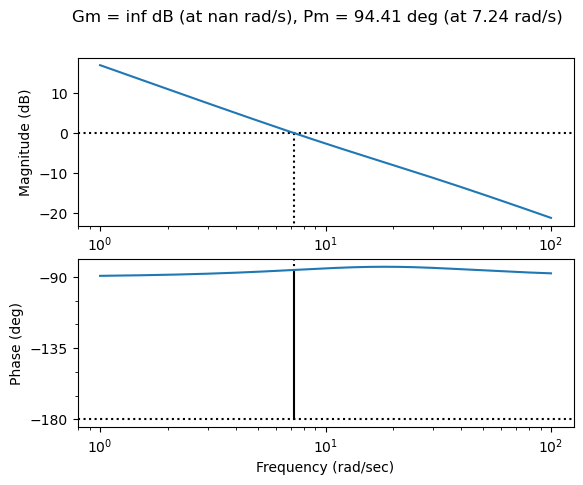

In [26]:
mag1, pm1, wg1 = ct.bode(L1, margins=True, dB=True)

The phase and gain margin are acceptable. Calculating the bandwidth

In [27]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx = find_nearest(ct.mag2db(mag1), -3)

omega_B1 = wg1[idx]

eq_disp('\\omega_B', round(omega_B1,3), 'rad/s')

<IPython.core.display.Latex object>

## Nyquist plot

The number of encirclements of the -1 point is displayed and the nyquist plot is made:

0

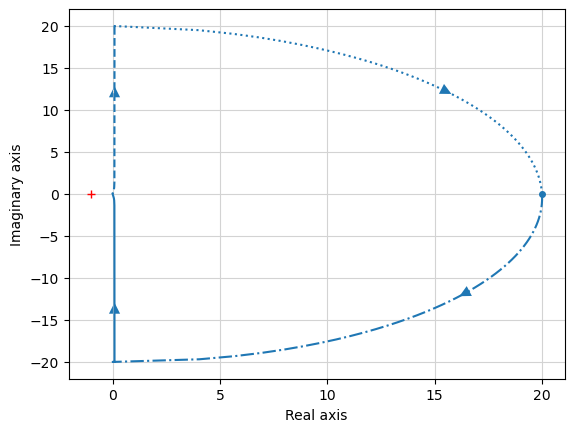

In [28]:
ct.nyquist_plot(L1)

## Nichols plot

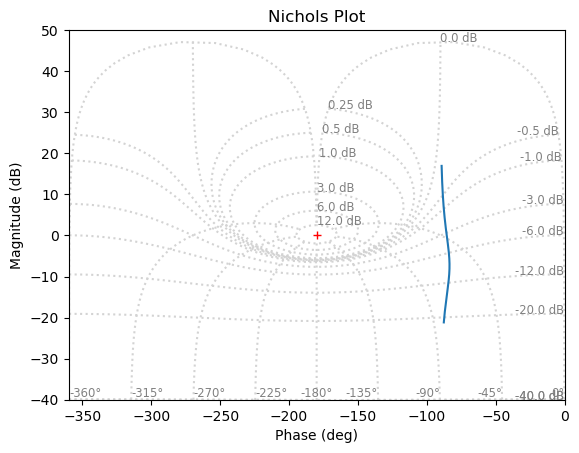

In [29]:
ct.nichols_plot(L1)

# PD-tuning of $\theta_2$

## Requirements

The same requirements as for $\theta_1$ are used.

## Using Ziegler-Nichols tuning

$K_d$ is set to zero while $K_p$ until it reaches the ultimate gain, $K_u$, where the system reaches marginal stability

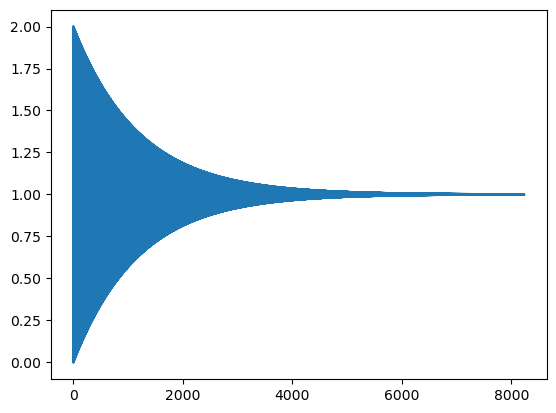

In [30]:
# Input PD-values
input_Kp2 = 1.001
input_Kd2 = 0

# Converted PD-values
Kp2 = input_Kp2*input_to_torque2
Kd2 = input_Kd2*input_to_torque2

# System definition
Gc2 = Kp2 + Kd2*s
L2 = Gc2*G2
T1 = ct.feedback(L2, H_pade2)

Ku2 = Kp2

t1_sim, y1_sim = ct.step_response(T1, T_num=100000)
plt.plot(t1_sim, y1_sim)

Then $K_p$ and $K_d$ values are calculated using the table.
https://en.m.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method

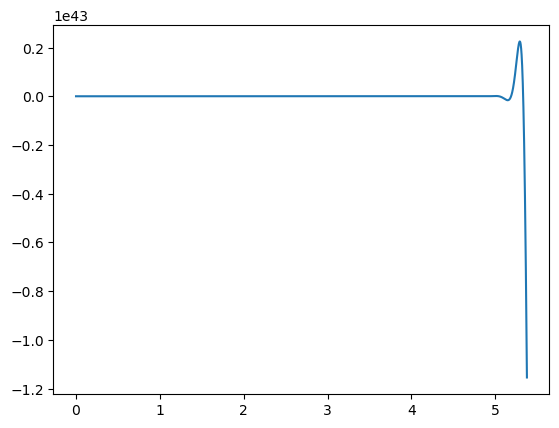

In [31]:
Tu2 = 1
input_Kp2 = 0.8*Ku2
input_Kd2 = 0.1*Ku2*Tu2

# Converted PD-values
Kp2 = input_Kp2*input_to_torque2
Kd2 = input_Kd2*input_to_torque2

# System definition
Gc2 = Kp2 + Kd2*s
L2 = Gc2*G2
T2 = ct.feedback(L2, H_pade2)

%matplotlib inline
t2_sim, y2_sim = ct.step_response(T2)
plt.plot(t2_sim, y2_sim)

## Using root locus - manual tuning

Closed loop system cannot reach marginal stabilty, as $K_p$ should be zero. The quarter amplitude decay is reached, by increasing $K_p$

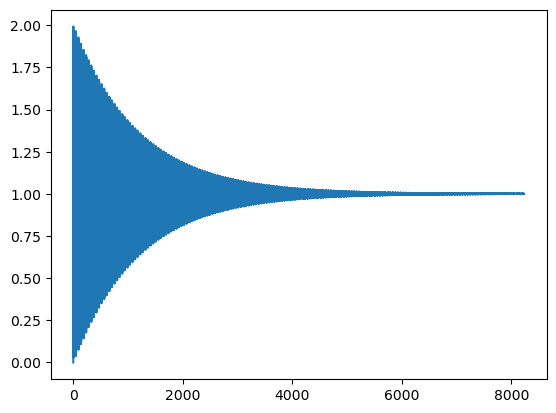

In [59]:
# Input PD-values
input_Kp2 = 1.001
input_Kd2 = 0

# Converted PD-values
Kp2 = input_Kp2*input_to_torque2
Kd2 = input_Kd2*input_to_torque2

# System definition
Gc2 = Kp2 + Kd2*s
L2 = Gc2*G2
T2 = ct.feedback(L2, H_pade2)

t2_sim, y2_sim = ct.step_response(T2)
plt.plot(t2_sim, y2_sim)

Reach the quarter amplitude decay, and tune $K_d$ to get desired characteristics

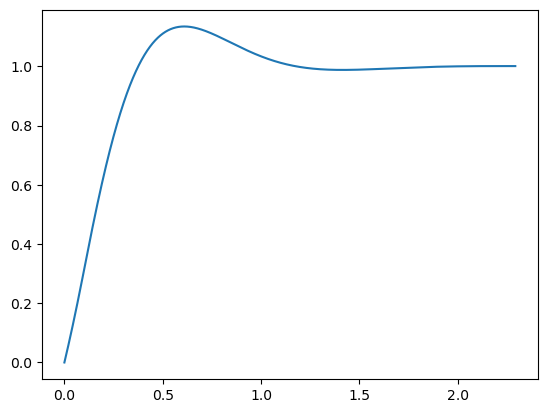

In [61]:
# Input PD-values
input_Kp2 = 0.45
input_Kd2 = 0.07

# Converted PD-values
Kp2 = input_Kp2*input_to_torque2
Kd2 = input_Kd2*input_to_torque2

# System definition
Gc2 = Kp2 + Kd2*s
L2 = Gc2*G2
T2 = ct.feedback(L2, H_pade2)

t2_sim, y2_sim = ct.step_response(T2)
plt.plot(t2_sim, y2_sim)

Root locus of uncompensated system with the characteristic equation found from
\begin{equation}
\frac{Y(s)}{R(s)}=\frac{KG(s)}{1+KG(s)},
\end{equation}

which gives the characteristic equation
\begin{equation}
1 + KG(s) = 0
\end{equation}

So for varying the proportional gain the root locus is


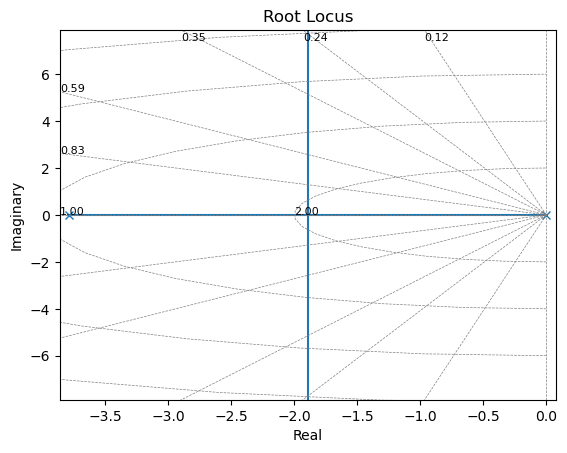

In [34]:
rlist1, klist1 = ct.rlocus(G2)

The root locus for varying the derivative gain, $K_D$

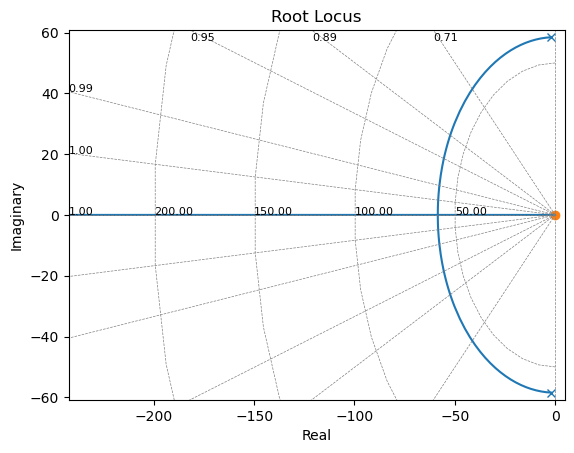

In [35]:
rlist1, klist1 = ct.rlocus(s*0.005263/(0.005263*s**2+0.01993*s + Kp2))

When $K_D$ increases the complex poles move to the left which
\begin{itemize}
    \item increases the associated damping ratio
    \item decrease the percent overshoot
    \item reduce the settling time
\end{itemize}

## Using the python PID-designer

Finding $K_p$

/Users/Mathias/opt/anaconda3/lib/python3.9/site-packages/control/freqplot.py:385: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_mag.axhline(y=0 if dB else 1, color='k', linestyle=':',


StateSpace(array([[  -3.78605556,    0.        ,    0.        ,    0.        ],
       [   1.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    1.        ,    0.        ,    0.        ],
       [   0.        ,  100.        ,    0.        , -100.        ]]), array([[  0.],
       [  0.],
       [  1.],
       [100.]]), array([[ 0., -1.,  0.,  0.]]), array([[0.]]))

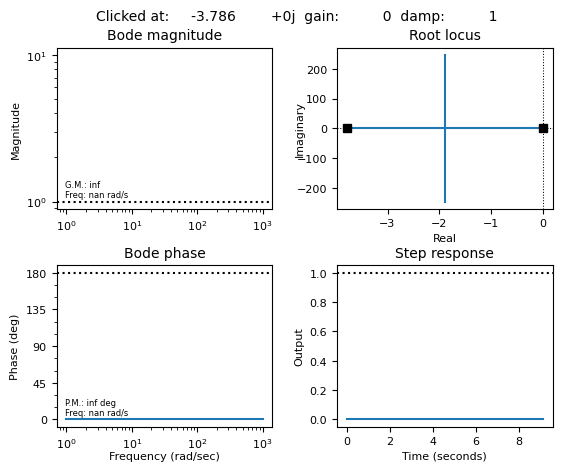

In [36]:
ct.rootlocus_pid_designer(G2)

Finding $K_D$

/Users/Mathias/opt/anaconda3/lib/python3.9/site-packages/control/freqplot.py:385: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_mag.axhline(y=0 if dB else 1, color='k', linestyle=':',


StateSpace(array([[  -3.78605556,  -18.        ,    0.        ,    0.        ],
       [   1.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    1.        ,    0.        ,    0.        ],
       [   0.        ,  100.        ,    0.        , -100.        ]]), array([[-18.],
       [  0.],
       [  1.],
       [100.]]), array([[ 0., -1.,  0.,  0.]]), array([[0.]]))

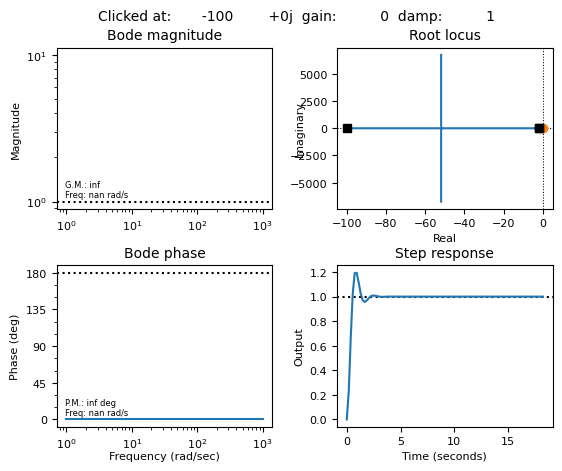

In [37]:
ct.rootlocus_pid_designer(G2, gain='D', Kp0=Kp2)

/Users/Mathias/opt/anaconda3/lib/python3.9/site-packages/control/freqplot.py:385: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_mag.axhline(y=0 if dB else 1, color='k', linestyle=':',


StateSpace(array([[  -3.78605556, -298.        ,    0.        ,  280.        ],
       [   1.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    1.        ,    0.        ,    0.        ],
       [   0.        ,  100.        ,    0.        , -100.        ]]), array([[-298.],
       [   0.],
       [   1.],
       [ 100.]]), array([[ 0., -1.,  0.,  0.]]), array([[0.]]))

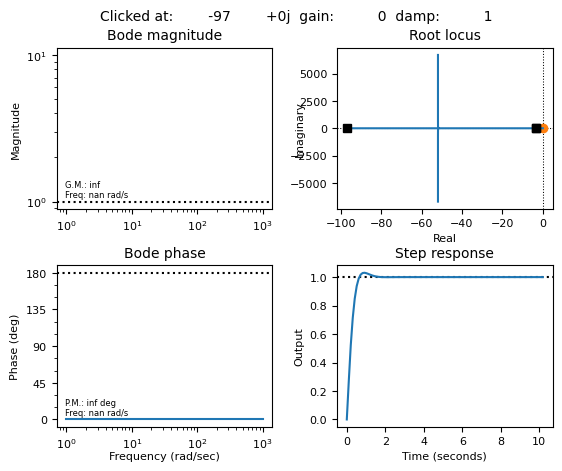

In [38]:
ct.rootlocus_pid_designer(G2, gain='D', Kp0=Kp2, Kd0=Kd2)

In [39]:
ct.step_info(T2)

{'RiseTime': 0.2784169348139648,
 'SettlingTime': 1.0595508925912522,
 'SettlingMin': 0.9002531119256838,
 'SettlingMax': 1.134783807954749,
 'Overshoot': 13.478380795474898,
 'Undershoot': 0,
 'Peak': 1.134783807954749,
 'PeakTime': 0.6095265887487311,
 'SteadyStateValue': 1.0}

Requirements are met with these values for $K_p$ and $K_D$

## Using frequency response methods

## Bode plot

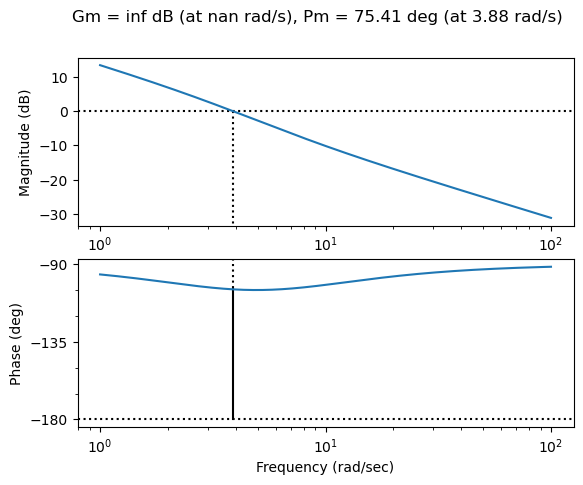

In [40]:
mag2, pm2, wg2 = ct.bode(L2, margins=True, dB=True)

The phase and gain margin are acceptable. Calculating the bandwidth

In [41]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx = find_nearest(ct.mag2db(mag2), -3)

omega_B2 = wg2[idx]

eq_disp('\\omega_B', round(omega_B2,3), 'rad/s')

<IPython.core.display.Latex object>

## Nyquist plot

The number of encirclements of the -1 point is displayed and the nyquist plot is made:

0

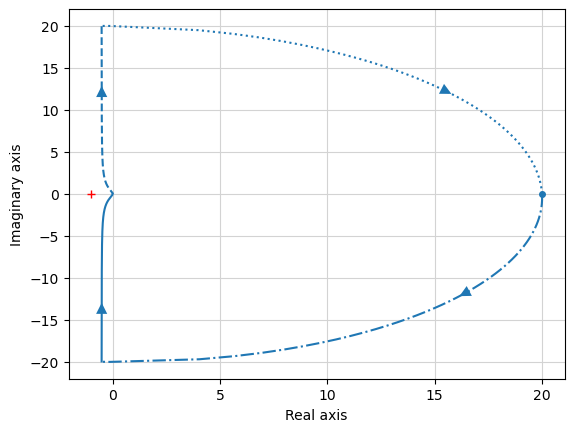

In [42]:
ct.nyquist_plot(L2)

## Nichols plot

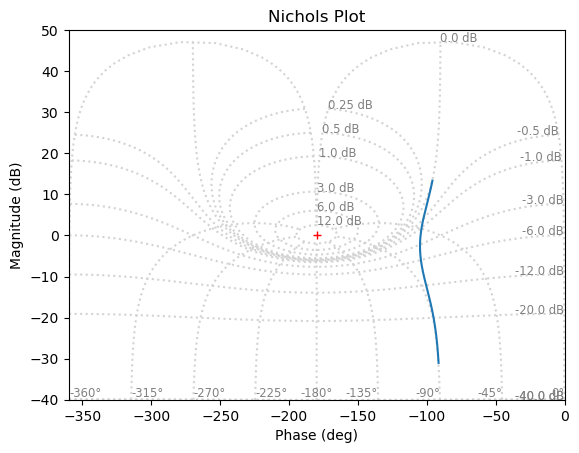

In [43]:
ct.nichols_plot(L2)

In [48]:
input_Kp1

3.6

In [49]:
input_Kd1

0.22

In [50]:
input_Kp2

0.45

In [51]:
input_Kd2

0.07